##  CATBOOST

### Importing All Libraries

In [7]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

### Loading The Dataset

In [8]:
# Load your dataset (replace "pd_speech_features.csv" with your actual file)
data = pd.read_csv("pd_speech_features.csv")
X = data.drop(columns=['class', 'id'])
y = data['class']

### Applying Scaling

In [9]:
# Scale the input data to the range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### Applying Feature selection

In [10]:
# Feature selection using ANOVA F-value
k = 300
anova_selector = SelectKBest(f_classif, k=k)
X_selected = anova_selector.fit_transform(X_scaled, y)

### Initialising Catboost Classifier

In [11]:
# Set up k-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the classifier (CatBoost as an example)
clf = CatBoostClassifier(iterations=1000,
    learning_rate=0.05,depth=6,l2_leaf_reg=1,random_strength=1,border_count=128,bagging_temperature=1,od_type='Iter',od_wait=20,
    eval_metric='Logloss',scale_pos_weight=1.0,one_hot_max_size=255,verbose=False)


### Applying K-Fold Cross Validation

Average Accuracy: 0.9325548971767166
Average Precision: 0.9417691630671324
Average Recall: 0.9697850821744627
Average F1 Score: 0.9553640319661559


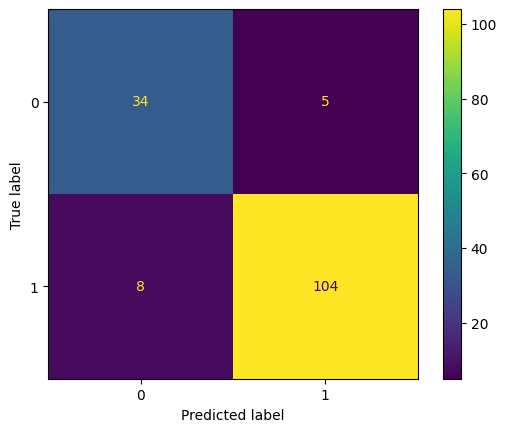

In [12]:
# Perform k-fold cross-validation
accuracies = []
precisions, recalls, f1_scores = [], [], [] 

for train_index, test_index in kf.split(X_selected, y):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply SMOTE only to the training data
    smote = SMOTE( sampling_strategy='auto',  # 'auto' or a float specifying the target ratio
    random_state=42,
    k_neighbors=5)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train the classifier
    clf.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_preds = clf.predict(X_test)
    

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)

    # Store metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Print average accuracy across folds
average_accuracy = np.mean(accuracies)

average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1 = np.mean(f1_scores)

print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1 Score:", average_f1)
print(ConfusionMatrixDisplay.from_predictions(y_true = y_test, 
                                        y_pred = y_preds))